In [1]:
# Install required libraries
!pip install yfinance timesfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requirements. This could take a while.
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.2/440.2 kB 32.9 MB/s et

In [1]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=57ba1ff0cb61ef162d922963ac494320716716ac08f912b9c3b5fa64de030838
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import os
import time
import timesfm
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


2024-09-04 09:46:55.949844: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia


In [3]:
# Load TimesFM model
timesfm_backend = "gpu"  # or 'cpu'
from jax._src import config
config.update("jax_platforms", {"cpu": "cpu", "gpu": "cuda", "tpu": ""}[timesfm_backend])

In [8]:
import yfinance as yf
import ta
import pandas as pd

# تنظیمات
ticker = 'AAPL'  # Example: Apple Inc.
start_date = "2000-10-12"
end_date = "2024-01-01"
analysis_start_date = "2023-01-03"  # تاریخ شروع مورد نظر

# دانلود داده‌های سهام از Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)
data = data.dropna()


# محاسبه میانگین‌های متحرک و اندیکاتورهای تکنیکال
data['moving_avg_10'] = data['Close'].rolling(window=10).mean()
data['moving_avg_50'] = data['Close'].rolling(window=50).mean()
data['rsi'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
data['ema'] = ta.trend.EMAIndicator(data['Close'], window=10).ema_indicator()




# تنظیم DataFrame نهایی
df = data[['Close', 'Volume', 'moving_avg_10', 'moving_avg_50', 'rsi', 'ema']].reset_index()
df.columns = ['date', 'close', 'volume', 'moving_avg_10', 'moving_avg_50', 'rsi', 'ema']
df['date'] = pd.to_datetime(df['date'])

df.set_index('date', inplace=True)

# نمایش داده‌ها
df


[*********************100%***********************]  1 of 1 completed


,close,volume,moving_avg_10,moving_avg_50,rsi,ema
date,,,,,,
2000-10-12,0.357143,1191064000,NaN,NaN,NaN,NaN
2000-10-13,0.393973,1247752800,NaN,NaN,NaN,NaN
2000-10-16,0.383929,820176000,NaN,NaN,NaN,NaN
2000-10-17,0.359375,601720000,NaN,NaN,NaN,NaN
2000-10-18,0.359375,834265600,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-12-22,193.600006,37122800,195.747002,185.398801,54.609714,194.957922
2023-12-26,193.050003,28919300,195.734003,185.682801,53.026883,194.611027
2023-12-27,193.149994,48087700,195.578001,185.971400,53.291938,194.345385


In [9]:
def get_batched_data_fn(context_len: int = 32, horizon_len: int = 1):
    examples = defaultdict(list)
    num_examples = 0
    for start in range(0, len(df) - (context_len + horizon_len), horizon_len):
        num_examples += 1
        context_end = start + context_len
        examples["inputs"].append(df["close"][start:context_end].tolist())
        examples["volume"].append(df["volume"][start:context_end].tolist() + [df["volume"].iloc[context_end - 1]])
        examples["outputs"].append(df["close"][context_end:context_end + horizon_len].tolist())
        examples["dates"].append(df.index[start:context_end + horizon_len].tolist())  # Add dates to examples

    def data_fn():
        for i in range(num_examples):
            yield {k: v[i] for k, v in examples.items()}

    return data_fn

In [10]:
import timesfm

context_len = 512
batch_size = 1  # ثابت نگه‌داشتن batch size
horizon_len = 1  # ثابت نگه‌داشتن horizon length



In [11]:

    model = timesfm.TimesFm(
        context_len=context_len,
        horizon_len=horizon_len,
        input_patch_len=32,
        output_patch_len=128,
        num_layers=20,
        model_dims=1280,
        backend="gpu",
    )
    model.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 3.89 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 3.77 seconds.
Jitting decoding.
Jitted decoding in 21.77 seconds.


In [12]:
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict

# Define context lengths to test
context_lengths = range(64, 513, 32)

# Define the start date and number of days to predict
analysis_start_date = pd.to_datetime("2023-04-05")

# Store results for different context lengths
results_by_context_len = []

for context_len in context_lengths:
    print(f"Processing context_len: {context_len}")

    # تنظیم داده‌ها
    start_idx = df.index.get_loc(analysis_start_date) - context_len

    # حلقه پیش‌بینی تا پایان داده‌ها
    while start_idx + context_len < len(df):
        # تعیین بازه زمانی بر اساس context_len
        end_idx = start_idx + context_len

        inputs = df['close'].iloc[start_idx:end_idx].tolist()

        # Prepare dynamic numerical covariates, e.g., volume
        dynamic_numerical_covariates = {
            "volume": df['volume'].iloc[start_idx:end_idx].tolist() + [df['volume'].iloc[end_idx-1]],
        }
        dynamic_numerical_covariates_formatted = {k: [v] for k, v in dynamic_numerical_covariates.items()}

        # Make the forecast using the model
        raw_forecast, _ = model.forecast(
            inputs=[inputs], freq=[0] * len(inputs)
        )

        # Make the forecast with covariates using the model
        cov_forecast, ols_forecast = model.forecast_with_covariates(
            inputs=[inputs],
            dynamic_numerical_covariates=dynamic_numerical_covariates_formatted,
            dynamic_categorical_covariates={},
            static_numerical_covariates={},
            static_categorical_covariates={},
            freq=[0] * len(inputs),
            normalize_xreg_target_per_input=True,
            xreg_mode="timesfm + xreg",
        )

        # Store the prediction date and actual values
        predict_date = df.index[end_idx]
        y_actual = df['close'].iloc[end_idx]

        # Append results to the list
        results_by_context_len.append({
            'context_len': context_len,
            'predict_date': predict_date,
            'raw_forecast': raw_forecast[0][0],
            'cov_forecast': cov_forecast[0][0],
            'train_start_date': df.index[start_idx],
            'train_end_date': df.index[end_idx-1],
            'y_actual': y_actual,
            'volume': dynamic_numerical_covariates["volume"],
        })

        # Increment start index for the next prediction
        start_idx += 1

# تبدیل نتایج به DataFrame
results_df = pd.DataFrame(results_by_context_len)





Processing context_len: 64
Processing context_len: 96
Processing context_len: 128
Processing context_len: 160
Processing context_len: 192
Processing context_len: 224
Processing context_len: 256
Processing context_len: 288
Processing context_len: 320
Processing context_len: 352
Processing context_len: 384
Processing context_len: 416
Processing context_len: 448
Processing context_len: 480
Processing context_len: 512


In [14]:

 results_df=results_df[:-1]

In [15]:
results_df

,context_len,predict_date,raw_forecast,cov_forecast,train_start_date,train_end_date,y_actual,volume
0,64,2023-04-05,166.959579,174.092331,2023-01-03,2023-04-04,163.759995,"[112117500, 89113600, 80962700, 87754700, 7079..."
1,64,2023-04-06,165.057480,175.042038,2023-01-04,2023-04-05,164.660004,"[89113600, 80962700, 87754700, 70790800, 63896..."
2,64,2023-04-10,165.524933,181.442688,2023-01-05,2023-04-06,162.029999,"[80962700, 87754700, 70790800, 63896200, 69458..."
3,64,2023-04-11,162.622726,177.749924,2023-01-06,2023-04-10,160.800003,"[87754700, 70790800, 63896200, 69458900, 71379..."
4,64,2023-04-12,161.525681,175.524063,2023-01-09,2023-04-11,160.100006,"[70790800, 63896200, 69458900, 71379600, 57809..."
...,...,...,...,...,...,...,...,...
2784,512,2023-12-21,195.222366,201.062866,2021-12-08,2023-12-20,194.679993,"[116998900, 108923700, 115402700, 153237000, 1..."
2785,512,2023-12-22,194.300446,201.103119,2021-12-09,2023-12-21,193.600006,"[108923700, 115402700, 153237000, 139380400, 1..."
2786,512,2023-12-26,193.330551,201.025482,2021-12-10,2023-12-22,193.050003,"[115402700, 153237000, 139380400, 131063300, 1..."
2787,512,2023-12-27,193.033722,201.737000,2021-12-13,2023-12-26,193.149994,"[153237000, 139380400, 131063300, 150185800, 1..."


In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score

def calculate_mse(y_actual, y_predicted):
    return mean_squared_error(y_actual, y_predicted)

def calculate_accuracy(y_actual, y_predicted):
    correct_predictions = 0
    total_predictions = 0
    for i in range(1, len(y_actual)):
        actual_today = y_actual.iloc[i]
        predicted_today = y_predicted.iloc[i]
        actual_yesterday = y_actual.iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1
    return correct_predictions / total_predictions if total_predictions > 0 else 0

def calculate_profit(y_actual, y_predicted, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(1, len(y_actual)):
        today_price = y_actual.iloc[i]
        yesterday_price = y_actual.iloc[i - 1]
        predicted_today_price = y_predicted.iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * y_actual.iloc[-1]

    return capital - initial_capital

def calculate_actual_direction_accuracy(y_actual, y_predicted):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(y_actual)):
        real_directions.append(get_direction(y_actual.iloc[i - 1], y_actual.iloc[i]))
        predicted_directions.append(get_direction(y_actual.iloc[i - 1], y_predicted.iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_accuracy(y_actual, y_predicted):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(y_actual)):
        real_directions.append(get_direction(y_actual.iloc[i - 1], y_actual.iloc[i]))
        predicted_directions.append(get_direction(y_predicted.iloc[i - 1], y_predicted.iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_profit(y_actual, y_predicted, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(2, len(y_actual)):
        yesterday_price = y_actual.iloc[i - 1]
        yesterday_predicted_today_price = y_predicted.iloc[i - 1]
        predicted_today_price = y_predicted.iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * y_actual.iloc[-1]

    return capital - initial_capital

def calculate_final_results(results_df):
    final_results = []

    for context_len in results_df['context_len'].unique():
        context_results_df = results_df[results_df['context_len'] == context_len]

        y_actual = context_results_df['y_actual']
        y_cov_forecast = context_results_df['cov_forecast']
        y_raw_forecast = context_results_df['raw_forecast']

        mse_value_cov = calculate_mse(y_actual, y_cov_forecast)
        accuracy_value_cov = calculate_accuracy(y_actual, y_cov_forecast)
        profit_cov = calculate_profit(y_actual, y_cov_forecast)
        direction_accuracy_cov = calculate_direction_accuracy(y_actual, y_cov_forecast)
        actual_direction_accuracy_cov = calculate_actual_direction_accuracy(y_actual, y_cov_forecast)
        direction_profit_cov = calculate_direction_profit(y_actual, y_cov_forecast)

        mse_value_raw = calculate_mse(y_actual, y_raw_forecast)
        accuracy_value_raw = calculate_accuracy(y_actual, y_raw_forecast)
        profit_raw = calculate_profit(y_actual, y_raw_forecast)
        direction_accuracy_raw = calculate_direction_accuracy(y_actual, y_raw_forecast)
        actual_direction_accuracy_raw = calculate_actual_direction_accuracy(y_actual, y_raw_forecast)
        direction_profit_raw = calculate_direction_profit(y_actual, y_raw_forecast)

        final_results.append({
            'context_len': context_len,
            'mse_cov': mse_value_cov,
            'accuracy_cov': accuracy_value_cov,
            'direction_accuracy_cov': direction_accuracy_cov,
            'actual_direction_accuracy_cov': actual_direction_accuracy_cov,
            'direction_profit_cov': direction_profit_cov,
            'profit_cov': profit_cov,
            'mse_raw': mse_value_raw,
            'accuracy_raw': accuracy_value_raw,
            'direction_accuracy_raw': direction_accuracy_raw,
            'actual_direction_accuracy_raw': actual_direction_accuracy_raw,
            'direction_profit_raw': direction_profit_raw,
            'profit_raw': profit_raw,
        })

    return pd.DataFrame(final_results)

# محاسبه نتایج نهایی
final_results = calculate_final_results(results_df)
print(final_results)


    context_len     mse_cov  accuracy_cov  direction_accuracy_cov  \
0            64  110.161017      0.475676                0.594595   
1            96   62.049741      0.502703                0.567568   
2           128   48.861128      0.518919                0.572973   
3           160   45.141763      0.535135                0.475676   
4           192   39.964895      0.524324                0.513514   
5           224   38.917138      0.518919                0.475676   
6           256   31.047416      0.524324                0.518919   
7           288   36.891439      0.535135                0.508108   
8           320   35.219998      0.518919                0.524324   
9           352   38.258805      0.545946                0.502703   
10          384   39.546371      0.524324                0.508108   
11          416   42.391906      0.508108                0.502703   
12          448   47.786317      0.551351                0.486486   
13          480   46.646375      0

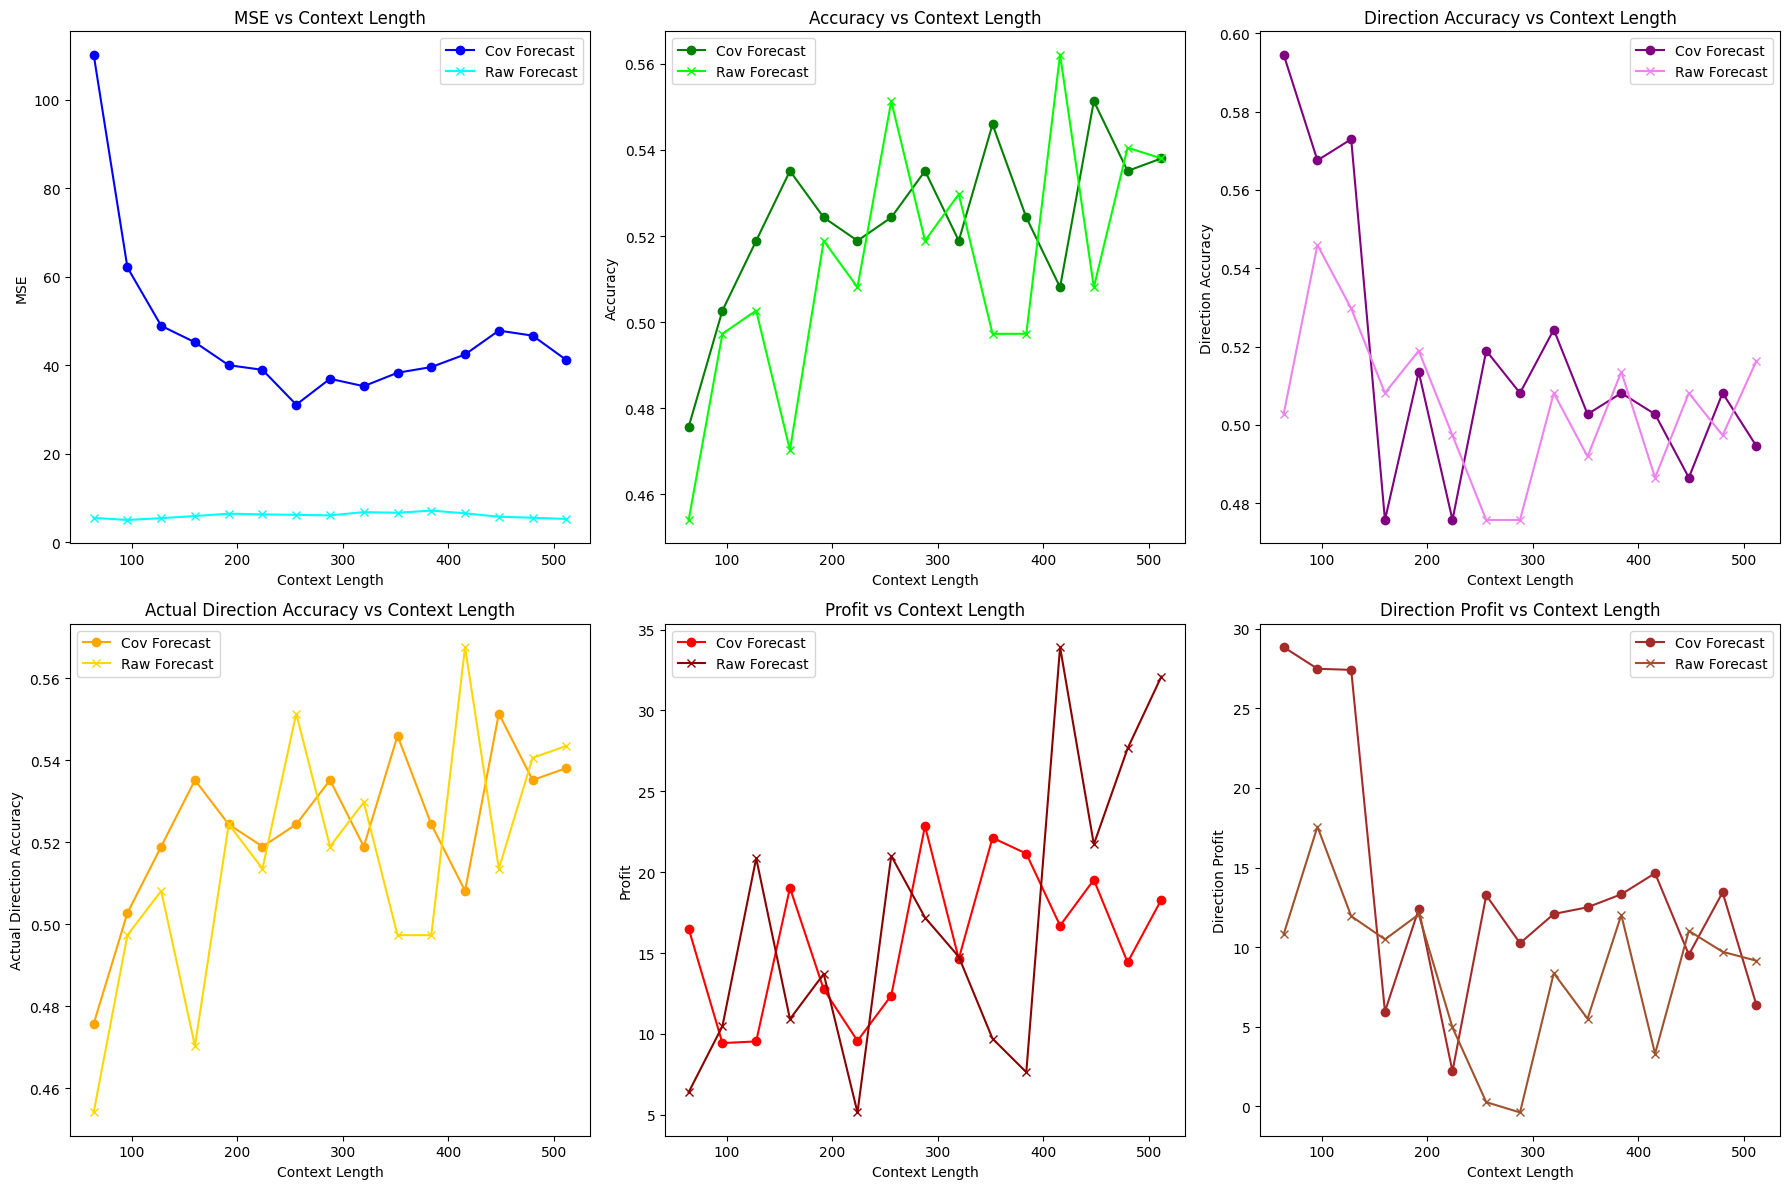

In [17]:
import matplotlib.pyplot as plt

# رسم نمودار تغییرات MSE، Accuracy، Direction Accuracy، Actual Direction Accuracy، Profit و Direction Profit بر حسب context_len
plt.figure(figsize=(18, 12))

# نمودار MSE
plt.subplot(2, 3, 1)
plt.plot(final_results['context_len'], final_results['mse_cov'], marker='o', color='blue', label='Cov Forecast')
plt.plot(final_results['context_len'], final_results['mse_raw'], marker='x', color='cyan', label='Raw Forecast')
plt.title('MSE vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('MSE')
plt.legend()

# نمودار Accuracy
plt.subplot(2, 3, 2)
plt.plot(final_results['context_len'], final_results['accuracy_cov'], marker='o', color='green', label='Cov Forecast')
plt.plot(final_results['context_len'], final_results['accuracy_raw'], marker='x', color='lime', label='Raw Forecast')
plt.title('Accuracy vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Accuracy')
plt.legend()

# نمودار Direction Accuracy
plt.subplot(2, 3, 3)
plt.plot(final_results['context_len'], final_results['direction_accuracy_cov'], marker='o', color='purple', label='Cov Forecast')
plt.plot(final_results['context_len'], final_results['direction_accuracy_raw'], marker='x', color='violet', label='Raw Forecast')
plt.title('Direction Accuracy vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Direction Accuracy')
plt.legend()

# نمودار Actual Direction Accuracy
plt.subplot(2, 3, 4)
plt.plot(final_results['context_len'], final_results['actual_direction_accuracy_cov'], marker='o', color='orange', label='Cov Forecast')
plt.plot(final_results['context_len'], final_results['actual_direction_accuracy_raw'], marker='x', color='gold', label='Raw Forecast')
plt.title('Actual Direction Accuracy vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Actual Direction Accuracy')
plt.legend()

# نمودار Profit
plt.subplot(2, 3, 5)
plt.plot(final_results['context_len'], final_results['profit_cov'], marker='o', color='red', label='Cov Forecast')
plt.plot(final_results['context_len'], final_results['profit_raw'], marker='x', color='darkred', label='Raw Forecast')
plt.title('Profit vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Profit')
plt.legend()

# نمودار Direction Profit
plt.subplot(2, 3, 6)
plt.plot(final_results['context_len'], final_results['direction_profit_cov'], marker='o', color='brown', label='Cov Forecast')
plt.plot(final_results['context_len'], final_results['direction_profit_raw'], marker='x', color='sienna', label='Raw Forecast')
plt.title('Direction Profit vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Direction Profit')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
# پیدا کردن context_len که بیشترین یا کمترین مقدار هر معیار را دارد برای Cov Forecast

# Minimum MSE برای Cov Forecast
min_mse_cov = final_results.loc[final_results['mse_cov'].idxmin()]
print(f"Minimum MSE (Cov Forecast): {min_mse_cov['mse_cov']} at Context Length: {min_mse_cov['context_len']}")

# Maximum Accuracy برای Cov Forecast
max_accuracy_cov = final_results.loc[final_results['accuracy_cov'].idxmax()]
print(f"Maximum Accuracy (Cov Forecast): {max_accuracy_cov['accuracy_cov']} at Context Length: {max_accuracy_cov['context_len']}")

# Maximum Direction Accuracy برای Cov Forecast
max_direction_accuracy_cov = final_results.loc[final_results['direction_accuracy_cov'].idxmax()]
print(f"Maximum Direction Accuracy (Cov Forecast): {max_direction_accuracy_cov['direction_accuracy_cov']} at Context Length: {max_direction_accuracy_cov['context_len']}")

# Maximum Actual Direction Accuracy برای Cov Forecast
max_actual_direction_accuracy_cov = final_results.loc[final_results['actual_direction_accuracy_cov'].idxmax()]
print(f"Maximum Actual Direction Accuracy (Cov Forecast): {max_actual_direction_accuracy_cov['actual_direction_accuracy_cov']} at Context Length: {max_actual_direction_accuracy_cov['context_len']}")

# Maximum Profit برای Cov Forecast
max_profit_cov = final_results.loc[final_results['profit_cov'].idxmax()]
print(f"Maximum Profit (Cov Forecast): {max_profit_cov['profit_cov']} at Context Length: {max_profit_cov['context_len']}")

# Maximum Direction Profit برای Cov Forecast
max_direction_profit_cov = final_results.loc[final_results['direction_profit_cov'].idxmax()]
print(f"Maximum Direction Profit (Cov Forecast): {max_direction_profit_cov['direction_profit_cov']} at Context Length: {max_direction_profit_cov['context_len']}")



Minimum MSE (Cov Forecast): 31.047415810349268 at Context Length: 256.0
Maximum Accuracy (Cov Forecast): 0.5513513513513514 at Context Length: 448.0
Maximum Direction Accuracy (Cov Forecast): 0.5945945945945946 at Context Length: 64.0
Maximum Actual Direction Accuracy (Cov Forecast): 0.5513513513513514 at Context Length: 448.0
Maximum Profit (Cov Forecast): 22.859037871898977 at Context Length: 288.0
Maximum Direction Profit (Cov Forecast): 28.843548980163632 at Context Length: 64.0


In [21]:

# پیدا کردن context_len که بیشترین یا کمترین مقدار هر معیار را دارد برای Raw Forecast

# Minimum MSE برای Raw Forecast
min_mse_raw = final_results.loc[final_results['mse_raw'].idxmin()]
print(f"Minimum MSE (Raw Forecast): {min_mse_raw['mse_raw']} at Context Length: {min_mse_raw['context_len']}")

# Maximum Accuracy برای Raw Forecast
max_accuracy_raw = final_results.loc[final_results['accuracy_raw'].idxmax()]
print(f"Maximum Accuracy (Raw Forecast): {max_accuracy_raw['accuracy_raw']} at Context Length: {max_accuracy_raw['context_len']}")

# Maximum Direction Accuracy برای Raw Forecast
max_direction_accuracy_raw = final_results.loc[final_results['direction_accuracy_raw'].idxmax()]
print(f"Maximum Direction Accuracy (Raw Forecast): {max_direction_accuracy_raw['direction_accuracy_raw']} at Context Length: {max_direction_accuracy_raw['context_len']}")

# Maximum Actual Direction Accuracy برای Raw Forecast
max_actual_direction_accuracy_raw = final_results.loc[final_results['actual_direction_accuracy_raw'].idxmax()]
print(f"Maximum Actual Direction Accuracy (Raw Forecast): {max_actual_direction_accuracy_raw['actual_direction_accuracy_raw']} at Context Length: {max_actual_direction_accuracy_raw['context_len']}")

# Maximum Profit برای Raw Forecast
max_profit_raw = final_results.loc[final_results['profit_raw'].idxmax()]
print(f"Maximum Profit (Raw Forecast): {max_profit_raw['profit_raw']} at Context Length: {max_profit_raw['context_len']}")

# Maximum Direction Profit برای Raw Forecast
max_direction_profit_raw = final_results.loc[final_results['direction_profit_raw'].idxmax()]
print(f"Maximum Direction Profit (Raw Forecast): {max_direction_profit_raw['direction_profit_raw']} at Context Length: {max_direction_profit_raw['context_len']}")

Minimum MSE (Raw Forecast): 4.989474772962601 at Context Length: 96.0
Maximum Accuracy (Raw Forecast): 0.5621621621621622 at Context Length: 416.0
Maximum Direction Accuracy (Raw Forecast): 0.5459459459459459 at Context Length: 96.0
Maximum Actual Direction Accuracy (Raw Forecast): 0.5675675675675675 at Context Length: 416.0
Maximum Profit (Raw Forecast): 33.91828377720242 at Context Length: 416.0
Maximum Direction Profit (Raw Forecast): 17.56299034872319 at Context Length: 96.0


In [19]:
initial_investment = 100
initial_price = results_df['y_actual'].iloc[0]
final_price = results_df['y_actual'].iloc[-1]


# Calculate the number of shares bought initially
shares_bought = initial_investment / initial_price

# Calculate the final value of the investment
final_investment_value = shares_bought * final_price

# Calculate the total profit
buy_and_hold_profit = final_investment_value - initial_investment
buy_and_hold_profit

18.209580071141218